## Model Training (Done on Google Collab)
### VGG19 train & tune
### DenseNet train & tune
### Xception train & tune

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Package & Dependencies Setup

In [2]:
"""Install NSL package"""
!pip install --upgrade neural_structured_learning
!pip install tensorflow-addons

     |████████████████████████████████| 122kB 20.0MB/s 
     |████████████████████████████████| 706kB 17.2MB/s 


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from neural_structured_learning.tools import graph_utils
import neural_structured_learning as nsl
import tensorflow_addons as tfa
from copy import deepcopy
from sklearn.metrics import multilabel_confusion_matrix
import random
import os
import PIL
import time
import re

tf.keras.backend.clear_session()
print("tensorflow version: ", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices('GPU') else "NOT AVAILABLE")

tensorflow version:  2.4.1
keras version 2.4.0
Eager mode:  True
GPU is available


In [4]:
from graph_data_processing import GraphDataProcess
from AAE_model import AAE
from Kmeans import KMeans, KMeansModels
from nsl_data_processing import GenerateTrainTestDict, NSLDataFormat
from AD_model_builder import AD_params, ADModelBuilder, AccEarlyStop

In [5]:
''' label definition: NonDemented - 0, VeryMildDemented - 1, MildDemented -2, ModerateDemented -3 '''
label_list = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
root_path = '/content/drive/MyDrive/AD Expriment II/graph_images/'
train_root_path = f'{root_path}train/'
test_root_path = f'{root_path}test/'

train_path_list = [f'{train_root_path}{label}/' for label in label_list]
train_tfr_list = [f'{train_root_path}{label}.tfr' for label in label_list]

test_path_list = [f'{test_root_path}{label}/' for label in label_list]
test_tfr_list = [f'{test_root_path}{label}.tfr' for label in label_list]

tfr_rep_list = [f'{train_root_path}{label}_AAErep.tfr' for label in label_list]

train_tfr_path = f'{train_root_path}train_data.tfr'

#2.VGG19 & VGG19-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = train_tfr_path

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

## 2.1 VGG19 Base Model Training
### val_acc: 0.64, val_auc: 0.89, val_f1_score: 0.64

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path = '/content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_base'
params.early_stop_base_line=0.90
params.train_epoch=50
"""build a base_model and restore weights from last training"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',  tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
base_model.load_weights(params.checkpoint_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                147488    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________

In [ ]:
'''train base model'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, 
                                                          mode='max',save_freq='epoch',options=None)

callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpoints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


    160/Unknown - 28s 159ms/step - loss: 1.0112 - accuracy: 0.5801 - auc: 0.8262 - f1_score: 0.4933

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


160/160 [==============================] - 31s 182ms/step - loss: 1.0101 - accuracy: 0.5805 - auc: 0.8265 - f1_score: 0.4937 - val_loss: 1.4173 - val_accuracy: 0.3753 - val_auc: 0.6352 - val_f1_score: 0.2414

Epoch 00001: val_accuracy improved from -inf to 0.37529, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_base
Epoch 2/50
160/160 [==============================] - 30s 181ms/step - loss: 0.6073 - accuracy: 0.7445 - auc: 0.9359 - f1_score: 0.6846 - val_loss: 1.1158 - val_accuracy: 0.5465 - val_auc: 0.8065 - val_f1_score: 0.4966

Epoch 00002: val_accuracy improved from 0.37529 to 0.54652, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_base
Epoch 3/50
160/160 [==============================] - 30s 179ms/step - loss: 0.5309 - accuracy: 0.7771 - auc: 0.9508 - f1_score: 0.7323 - val_loss: 1.4043 - val_accuracy: 0.4934 - val_auc: 0.7588 - val_f1_score: 0.4842

Epoch 00003: val_accuracy did not impr

In [ ]:
'''evaluate the base model'''
base_model.evaluate(test_image_dataset)

1/1 [==============================] - 3s 3s/step - loss: 1.4312 - accuracy: 0.6403 - auc: 0.8503 - f1_score: 0.6390


[1.4311827421188354,
 0.6403440237045288,
 0.8503028750419617,
 0.6390205025672913]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

In [ ]:
len(data)

1279

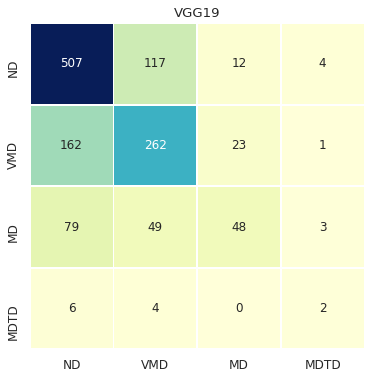

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "VGG19")

## 2.2 VGG19-NSL Model Training
### val_acc: 0.63, val_auc: 0.82 , val_f1_score: 0.63 

In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_path ='/content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl'
params.early_stop_base_line=0.70
params.train_epoch=30
params.nsl_multiplier = 0.01
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

"""build a base_model"""
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').get_ADModel()

"""build a NSL model on top of the base model and retore weights from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)

graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)

graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.checkpoint_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
Model: "VGG19_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                73744     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________

In [ ]:
''' setup early stoping and checkpoints '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)

callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

'''NSL model training'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


160/160 [==============================] - 78s 474ms/step - loss: 0.1486 - accuracy: 0.9443 - auc: 0.9957 - f1_score: 0.9432 - scaled_graph_loss: 6.7404e-04 - val_loss: 1.9059 - val_accuracy: 0.6153 - val_auc: 0.8326 - val_f1_score: 0.9033

Epoch 00001: val_accuracy improved from -inf to 0.61532, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl
Epoch 2/30
160/160 [==============================] - 75s 463ms/step - loss: 0.1538 - accuracy: 0.9393 - auc: 0.9955 - f1_score: 0.9403 - scaled_graph_loss: 6.9551e-04 - val_loss: 2.6825 - val_accuracy: 0.5559 - val_auc: 0.7794 - val_f1_score: 0.5570

Epoch 00002: val_accuracy did not improve from 0.61532
Epoch 3/30
160/160 [==============================] - 74s 461ms/step - loss: 0.1642 - accuracy: 0.9378 - auc: 0.9948 - f1_score: 0.9373 - scaled_graph_loss: 7.2718e-04 - val_loss: 3.1422 - val_accuracy: 0.5176 - val_auc: 0.7519 - val_f1_score: 0.5169

Epoch 00003: val_accuracy did not improve from

In [ ]:
graph_reg_model.evaluate(test_image_dataset)

20/20 [==============================] - 2s 74ms/step - loss: 2.3366 - accuracy: 0.6357 - auc: 0.8260 - f1_score: 0.6355


[2.3365843296051025, 0.6356528401374817, 0.8260239958763123, 0.635469913482666]

## 2.3 VGG19-NSL Model tunning
### val_acc: 0.68, val_auc: 0.86, val_f1_score: 0.68

In [ ]:
'''define params'''
params.learning_rate = 0.000005
params.checkpoint_restore_path = '/content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl'
params.checkpoint_path= '/content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl_tuning'
params.early_stop_base_line=0.70
params.train_epoch=50
params.nsl_multiplier = 0.005
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE
'''build base model'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='vgg19').setup_VGG19_by_layer_names(trainable_layers=['block1_conv1', 'block3_conv4' ,'block5_conv4']).get_ADModel()

"""restore NSL model from last training"""
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type, 
                                                     sum_over_axis= params.nsl_sum_over_axis)

graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)

graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])

graph_reg_model.load_weights(params.checkpoint_path)

Note: default vgg19 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Setup specific trainable layers in setup_VGG19_by_layer_names or setup_VGG19 function based on the VGG19 layer name or layer number
trainable layer:  block1_conv1
trainable layer:  block3_conv4
trainable layer:  block5_conv4
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
________________________________________________________

In [ ]:
"""set up training checkpoint and earlystop callbacks"""
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')

callback_earlystop = AccEarlyStop(val_acc_base = params.early_stop_base_line)

"""NSL model training"""
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs= params.train_epoch,
                                        verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


160/160 [==============================] - 71s 428ms/step - loss: 0.0342 - accuracy: 0.9904 - auc: 0.9999 - f1_score: 0.9901 - scaled_graph_loss: 7.0651e-05 - val_loss: 2.9772 - val_accuracy: 0.5942 - val_auc: 0.7943 - val_f1_score: 0.9461

Epoch 00001: val_accuracy improved from -inf to 0.59421, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl_tuning
Epoch 2/50
160/160 [==============================] - 73s 451ms/step - loss: 0.0340 - accuracy: 0.9903 - auc: 0.9998 - f1_score: 0.9904 - scaled_graph_loss: 7.8045e-05 - val_loss: 1.9575 - val_accuracy: 0.6873 - val_auc: 0.8606 - val_f1_score: 0.6872

Epoch 00002: val_accuracy improved from 0.59421 to 0.68726, saving model to /content/drive/MyDrive/AD Expriment II/VGG19_model_checkpoints/vgg19_weights_nsl_tuning
Epoch 3/50
160/160 [==============================] - 76s 471ms/step - loss: 0.0370 - accuracy: 0.9896 - auc: 0.9996 - f1_score: 0.9895 - scaled_graph_loss: 8.0414e-05 - val_loss: 3.

In [ ]:
"""evaluate tuned model"""
graph_reg_model.evaluate(test_image_dataset)

1/1 [==============================] - 2s 2s/step - loss: 1.9575 - accuracy: 0.6873 - auc: 0.8606 - f1_score: 0.6872


[1.9574897289276123,
 0.6872556805610657,
 0.8606342077255249,
 0.6871552467346191]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

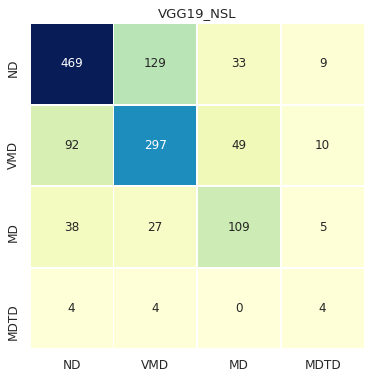

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, "VGG19_NSL")

# 3.DenseNet121 & DenseNet121-NSL Model Training

In [ ]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=128
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = train_tfr_path

'''parse train_data.tfr to train image dataset with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 64 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

## 3.1 DenseNet Base Model Training
### val_acc: 0.61, val_auc: 0.85, val_f1_score: 0.60 

In [ ]:
'''define params'''
params.learning_rate=0.005
params.checkpoint_restore_path='/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_weights'
params.checkpoint_path='/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_weights'
params.early_stop_base_line=0.70
params.train_epoch=50

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()

base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])

# base_model.load_weights(params.checkpoint_restore_path)

'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)

callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "DenseNet121_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                294944    
_________________________________________

In [ ]:
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     80/Unknown - 26s 240ms/step - loss: 1.0793 - accuracy: 0.5513 - auc: 0.8067 - f1_score: 0.5097

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


80/80 [==============================] - 29s 279ms/step - loss: 1.0771 - accuracy: 0.5519 - auc: 0.8073 - f1_score: 0.5103 - val_loss: 1.1650 - val_accuracy: 0.5113 - val_auc: 0.8189 - val_f1_score: 0.5029

Epoch 00001: val_accuracy improved from -inf to 0.51134, saving model to /content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_weights
Epoch 2/50
80/80 [==============================] - 20s 240ms/step - loss: 0.6907 - accuracy: 0.6897 - auc: 0.9137 - f1_score: 0.6640 - val_loss: 1.0876 - val_accuracy: 0.5199 - val_auc: 0.8202 - val_f1_score: 0.5060

Epoch 00002: val_accuracy improved from 0.51134 to 0.51994, saving model to /content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_weights
Epoch 3/50
80/80 [==============================] - 20s 238ms/step - loss: 0.6191 - accuracy: 0.7267 - auc: 0.9305 - f1_score: 0.7107 - val_loss: 0.9327 - val_accuracy: 0.5614 - val_auc: 0.8416 - val_f1_score: 0.5304

Epoch 00003: val_accuracy improved from 0.

In [ ]:
'''evaluate base model'''
base_model.evaluate(test_image_dataset)

1/1 [==============================] - 1s 1s/step - loss: 1.1089 - accuracy: 0.6106 - auc: 0.8511 - f1_score: 0.5994


[1.1089028120040894,
 0.6106333136558533,
 0.8510772585868835,
 0.5994260311126709]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

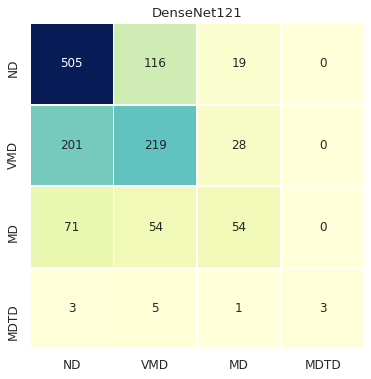

In [ ]:
ADModelBuilder.plot_confusion_mat(base_model, data, data_label, "DenseNet121")

## 3.2 DenseNet_NSL Model Training
### val_acc: 0.60, val_auc: 0.85, val_f1_score: 0.59



In [ ]:
'''define params'''
params.learning_rate=0.005
params.restore_path = '/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights'
params.checkpoint_path = '/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights'
params.early_stop_base_line=0.65
params.train_epoch=50
params.nsl_multiplier = 0.005
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').get_ADModel()

'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])

# graph_reg_model.load_weights(params.restore_path)
'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "DenseNet121_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 3, 3, 1024)        7037504   
_________________________________________________________________
flatten_6 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 9216)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                294944    
_________________________________________

In [ ]:
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


80/80 [==============================] - 69s 633ms/step - loss: 0.9899 - accuracy: 0.5700 - auc: 0.8274 - f1_score: 0.5272 - scaled_graph_loss: 7.1967e-04 - val_loss: 0.9882 - val_accuracy: 0.5403 - val_auc: 0.8239 - val_f1_score: 0.5757

Epoch 00001: val_accuracy improved from -inf to 0.54027, saving model to /content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights
Epoch 2/50
80/80 [==============================] - 43s 527ms/step - loss: 0.6759 - accuracy: 0.7045 - auc: 0.9178 - f1_score: 0.6812 - scaled_graph_loss: 5.7534e-04 - val_loss: 1.0293 - val_accuracy: 0.5426 - val_auc: 0.8313 - val_f1_score: 0.5348

Epoch 00002: val_accuracy improved from 0.54027 to 0.54261, saving model to /content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights
Epoch 3/50
80/80 [==============================] - 42s 517ms/step - loss: 0.5909 - accuracy: 0.7378 - auc: 0.9366 - f1_score: 0.7239 - scaled_graph_loss: 5.7662e-04 - val_loss: 1.0261 - v

In [ ]:
graph_reg_model.evaluate(test_image_dataset)

1/1 [==============================] - 1s 1s/step - loss: 1.0724 - accuracy: 0.6083 - auc: 0.8544 - f1_score: 0.6005


[1.0724372863769531,
 0.6082877516746521,
 0.8544427752494812,
 0.6004882454872131]

## 3.3 DenseNet_NSL top 20 layers and bottom 20 laysers tuning
### val_acc: 0.73, val_auc: 0.89, val_f1_score: 0.73

In [ ]:
'''redefine hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = train_tfr_path

'''parse train_data.tfr to train image dataset with batch_size at 64'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 64 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

In [ ]:
params.learning_rate=0.0001
params.restore_path= '/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights'
params.checkpoint_path = '/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights'
params.early_stop_base_line=0.80
params.train_epoch=50
params.nsl_multiplier = 0.0005
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=20, middle_layers=None, bottom_layers=30).get_ADModel()

'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])

'''restore the model from last training'''
graph_reg_model.load_weights(params.restore_path)

''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
29089792/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
_________________

In [ ]:
# train the model
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


160/160 [==============================] - 152s 855ms/step - loss: 0.0375 - accuracy: 0.9868 - auc: 0.9996 - f1_score: 0.9867 - scaled_graph_loss: 7.8527e-06 - val_loss: 1.7916 - val_accuracy: 0.6787 - val_auc: 0.8602 - val_f1_score: 0.9518

Epoch 00001: val_accuracy improved from -inf to 0.67866, saving model to /content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights
Epoch 2/50
160/160 [==============================] - 136s 843ms/step - loss: 0.0354 - accuracy: 0.9877 - auc: 0.9996 - f1_score: 0.9876 - scaled_graph_loss: 8.3765e-06 - val_loss: 2.1548 - val_accuracy: 0.6591 - val_auc: 0.8469 - val_f1_score: 0.6585

Epoch 00002: val_accuracy did not improve from 0.67866
Epoch 3/50
160/160 [==============================] - 136s 843ms/step - loss: 0.0394 - accuracy: 0.9853 - auc: 0.9992 - f1_score: 0.9854 - scaled_graph_loss: 8.6871e-06 - val_loss: 1.9432 - val_accuracy: 0.6654 - val_auc: 0.8628 - val_f1_score: 0.6664

Epoch 00003: val_accuracy did not imp

In [ ]:
'''evalute the test model'''
graph_reg_model.evaluate(test_image_dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


20/20 [==============================] - 41s 171ms/step - loss: 1.6862 - accuracy: 0.7479 - auc: 0.8971 - f1_score: 0.7461


[1.6922053098678589,
 0.7349491715431213,
 0.8940041661262512,
 0.7341175675392151]

## 3.4 DenseNet_NSL top 10 layers, middle 20 layers and bottom 10 laysers tuning
### val_acc: 0.74, val_auc: 0.89, val_f1_score: 0.74

In [ ]:
'''define params'''
params.learning_rate=0.000005
params.restore_path= '/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights'
params.checkpoint_path = '/content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights'
params.early_stop_base_line=0.80
params.train_epoch=50
params.nsl_multiplier = 0.00005
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build a base model with selected trainable layer'''
admodel = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='densenet121').setup_DenseNet121(top_layers=10, middle_layers=[190, 210], bottom_layers=10).get_ADModel()

'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis= params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(admodel,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                        loss=tf.losses.CategoricalCrossentropy(), 
                        metrics=["accuracy","AUC", tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])

'''restore the model from last training'''
graph_reg_model.load_weights(params.restore_path)

Note: default DenseNet121 not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_DenseNet121 function based on the "Layer Number"
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________

In [ ]:
''' NSL model training '''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                          save_freq='epoch',options=None)

callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


160/160 [==============================] - 296s 2s/step - loss: 0.0068 - accuracy: 0.9980 - auc: 1.0000 - f1_score: 0.9980 - scaled_graph_loss: 1.6752e-07 - val_loss: 2.4455 - val_accuracy: 0.6904 - val_auc: 0.8527 - val_f1_score: 0.9642

Epoch 00001: val_accuracy improved from -inf to 0.69038, saving model to /content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights
Epoch 2/50
160/160 [==============================] - 252s 2s/step - loss: 0.0103 - accuracy: 0.9970 - auc: 0.9999 - f1_score: 0.9969 - scaled_graph_loss: 2.4588e-07 - val_loss: 2.0046 - val_accuracy: 0.7170 - val_auc: 0.8742 - val_f1_score: 0.7173

Epoch 00002: val_accuracy improved from 0.69038 to 0.71697, saving model to /content/drive/MyDrive/AD Expriment II/DenseNet_model_checkpoints/densenet_nsl_weights
Epoch 3/50
160/160 [==============================] - 252s 2s/step - loss: 0.0112 - accuracy: 0.9967 - auc: 0.9998 - f1_score: 0.9967 - scaled_graph_loss: 2.3518e-07 - val_loss: 2.8941 - v

In [ ]:
'''evalute the test model'''
graph_reg_model.evaluate(test_image_dataset)

20/20 [==============================] - 3s 111ms/step - loss: 1.8784 - accuracy: 0.7193 - auc: 0.8743 - f1_score: 0.7188


[1.8783780336380005,
 0.7193119525909424,
 0.8742884993553162,
 0.7188110947608948]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

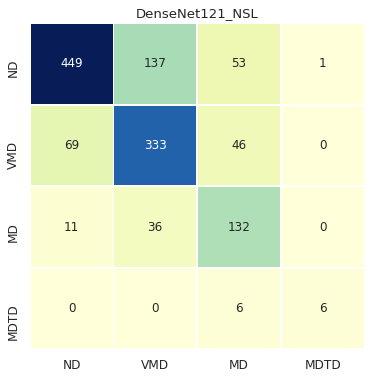

In [ ]:
ADModelBuilder.plot_confusion_mat(graph_reg_model, data, data_label, title="DenseNet121_NSL")

#4.Xception & Xception-NSL Model Training

In [6]:
'''define hyper params'''
params = AD_params()
params.max_seed_nbr=5
params.batch_size=64
params.image_channels =3
params.image_size =(100,100)
params.ad_base_model_input_shape=(100,100,3)
params.train_tfr_path = train_tfr_path

'''parse train_data.tfr to train image dataset with batch_size at 128'''
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[params.train_tfr_path],
                                                         batch_size=params.batch_size,
                                                         max_neighbor_number=params.max_seed_nbr,
                                                         image_size=params.image_size,
                                                         image_channels=params.image_channels,
                                                         shuffle=True)

'''load test data with batch_size at 128 '''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=params.batch_size, 
                                                                  size=params.image_size,
                                                                  channels=params.image_channels,
                                                                  shuffle=True)

##5.1 Xception Base Model Training
### val_acc: 0.51, val_auc: 0.81, val_f1_score: 0.51


In [ ]:
'''define params'''
params.learning_rate=0.001
params.checkpoint_restore_path='/content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_weights'
params.checkpoint_path='/content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_model_weights'
params.early_stop_base_line=0.60
params.train_epoch=30

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').get_ADModel()
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True), 
                   loss=tf.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy', 'AUC',tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# base_model.load_weights(params.checkpoint_restore_path)

'''set up check point & early stopping'''
callback_checkpints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "Xception_ADModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tensor (InputLayer)          [(None, 100, 100, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                589856    
__________________________________________________

In [ ]:
'''train base model'''
history = base_model.fit(train_image_dataset,
                         validation_data= test_image_dataset,
                         callbacks = [callback_checkpints, callback_earlystop],
                         epochs=params.train_epoch,
                         verbose=1)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['NL_nbr_0_id', 'NL_nbr_0_tensor', 'NL_nbr_0_weight', 'NL_nbr_1_id', 'NL_nbr_1_tensor', 'NL_nbr_1_weight', 'NL_nbr_2_id', 'NL_nbr_2_tensor', 'NL_nbr_2_weight', 'NL_nbr_3_id', 'NL_nbr_3_tensor', 'NL_nbr_3_weight', 'NL_nbr_4_id', 'NL_nbr_4_tensor', 'NL_nbr_4_weight', 'id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


    160/Unknown - 59s 124ms/step - loss: 1.1355 - accuracy: 0.5316 - auc: 0.7867 - f1_score: 0.4946

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


160/160 [==============================] - 64s 156ms/step - loss: 1.1344 - accuracy: 0.5319 - auc: 0.7870 - f1_score: 0.4950 - val_loss: 1.1197 - val_accuracy: 0.4801 - val_auc: 0.7941 - val_f1_score: 0.4718

Epoch 00001: val_accuracy improved from -inf to 0.48006, saving model to /content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_model_weights
Epoch 2/30
160/160 [==============================] - 22s 129ms/step - loss: 0.7607 - accuracy: 0.6624 - auc: 0.8967 - f1_score: 0.6388 - val_loss: 1.1126 - val_accuracy: 0.5051 - val_auc: 0.7960 - val_f1_score: 0.4757

Epoch 00002: val_accuracy improved from 0.48006 to 0.50508, saving model to /content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_model_weights
Epoch 3/30
160/160 [==============================] - 21s 130ms/step - loss: 0.6868 - accuracy: 0.7051 - auc: 0.9161 - f1_score: 0.6744 - val_loss: 0.9871 - val_accuracy: 0.5121 - val_auc: 0.8195 - val_f1_score: 0.4814

Epoch 00003: val_accurac

In [ ]:
"""evaluate base_model"""
base_model.evaluate(test_image_dataset)

20/20 [==============================] - 2s 55ms/step - loss: 1.1302 - accuracy: 0.5176 - auc: 0.8152 - f1_score: 0.5038


[1.1301771402359009, 0.5175918936729431, 0.8152245283126831, 0.503753125667572]

In [ ]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

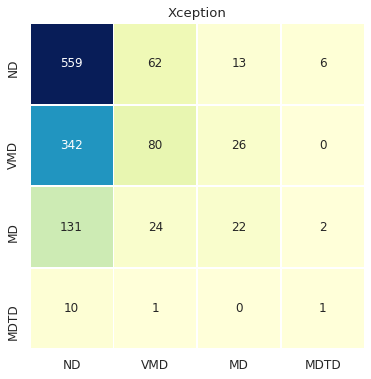

In [ ]:
ADModelBuilder.plot_confusion_mat(model=base_model, data=data, data_label=data_label, title="Xception", figsize=(6,6))

##5.2 Xception_NSL Model Training
### val_acc: 0.954,val_auc: 0.990,val_f1_score:0.954

In [ ]:
'''define params'''
params.learning_rate=0.00005
params.restore_path = '/content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_nsl_weights'
params.checkpoint_path = '/content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_nsl_weights'
params.early_stop_base_line=0.70
params.train_epoch=50
params.nsl_multiplier = 0.005
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=3, middle_layers=None, bottom_layers=3).get_ADModel()

'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
# graph_reg_model.load_weights(params.restore_path)

'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)


Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_16[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
___________________________________________________________________________________________

In [ ]:
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


160/160 [==============================] - 168s 971ms/step - loss: 1.4634 - accuracy: 0.4121 - auc: 0.6750 - f1_score: 0.3626 - scaled_graph_loss: 0.0015 - val_loss: 1.0589 - val_accuracy: 0.5004 - val_auc: 0.7897 - val_f1_score: 0.4334

Epoch 00001: val_accuracy improved from -inf to 0.50039, saving model to /content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_nsl_weights
Epoch 2/50
160/160 [==============================] - 141s 875ms/step - loss: 0.9879 - accuracy: 0.5918 - auc: 0.8337 - f1_score: 0.5533 - scaled_graph_loss: 0.0011 - val_loss: 1.0661 - val_accuracy: 0.5012 - val_auc: 0.8020 - val_f1_score: 0.4663

Epoch 00002: val_accuracy improved from 0.50039 to 0.50117, saving model to /content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_nsl_weights
Epoch 3/50
160/160 [==============================] - 141s 877ms/step - loss: 0.8619 - accuracy: 0.6412 - auc: 0.8714 - f1_score: 0.6066 - scaled_graph_loss: 9.6428e-04 - val_loss: 1.0264 - 

##5.3 Xception_NSL Model top 10 and bottom 5 layers tunning
### val_acc: 0.61, val_auc: 0.83, val_f1_score: 0.61


In [7]:
'''define params'''
params.learning_rate=0.00001
params.restore_path = '/content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_nsl_weights'
params.checkpoint_path = '/content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_nsl_weights'
params.early_stop_base_line=0.80
params.train_epoch=50
params.nsl_multiplier = 0.0005
params.nsl_sum_over_axis = -1
params.nsl_distance_type = nsl.configs.DistanceType.COSINE

'''build base_model and restore from the last training'''
base_model = ADModelBuilder(input_shape=params.ad_base_model_input_shape, base_model='xception').setup_Xception(top_layers=10, middle_layers=None, bottom_layers=5).get_ADModel()

'''build NSL model on top of base model'''
graph_reg_config = nsl.configs.make_graph_reg_config(neighbor_prefix=params.neighbor_prefix,
                                                     neighbor_weight_suffix=params.neighbor_weight_suffix,
                                                     max_neighbors= params.max_seed_nbr,
                                                     multiplier= params.nsl_multiplier,
                                                     distance_type= params.nsl_distance_type,
                                                     sum_over_axis=params.nsl_sum_over_axis)
graph_reg_model = nsl.keras.GraphRegularization(base_model,graph_reg_config)
graph_reg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params.learning_rate, amsgrad=True),
                        loss=tf.losses.CategoricalCrossentropy(),
                        metrics=["accuracy","AUC",tfa.metrics.F1Score(num_classes=4, average="micro", threshold = 0.5)])
graph_reg_model.load_weights(params.restore_path)

'''set up check point & early stopping'''
callback_checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath= params.checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max',
                                                         save_freq='epoch',options=None)
callback_earlystop = AccEarlyStop(val_acc_base=params.early_stop_base_line)

Note: default Xception not includes top and has imagenet weights. It is not a trainable model in ADModelBuilder. Please setup trainable layers in setup_Xception function based on the "Layer Number"
83689472/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________

In [8]:
'''train the nsl model'''
graph_reg_history = graph_reg_model.fit(train_image_dataset, 
                                        validation_data=test_image_dataset,
                                        callbacks = [callback_checkpoints, callback_earlystop],
                                        epochs=params.train_epoch,
                                        verbose=1)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['id'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/GraphRegularization/graph_loss/Reshape:0", shape=(None, 4), dtype=float32), dense_shape=Tensor("gradient_tape/GraphRegularization/graph_loss/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


160/160 [==============================] - 213s 998ms/step - loss: 0.1510 - accuracy: 0.9601 - auc: 0.9966 - f1_score: 0.9561 - scaled_graph_loss: 2.6864e-05 - val_loss: 1.3546 - val_accuracy: 0.6067 - val_auc: 0.8324 - val_f1_score: 0.9201

Epoch 00001: val_accuracy improved from -inf to 0.60672, saving model to /content/drive/MyDrive/AD Expriment II/Xception_model_checkpoints/Xception_nsl_weights
Epoch 2/50
160/160 [==============================] - 154s 959ms/step - loss: 0.1339 - accuracy: 0.9676 - auc: 0.9979 - f1_score: 0.9653 - scaled_graph_loss: 2.3016e-05 - val_loss: 1.3802 - val_accuracy: 0.5958 - val_auc: 0.8324 - val_f1_score: 0.5945

Epoch 00002: val_accuracy did not improve from 0.60672
Epoch 3/50
160/160 [==============================] - 154s 961ms/step - loss: 0.1138 - accuracy: 0.9721 - auc: 0.9987 - f1_score: 0.9701 - scaled_graph_loss: 2.0502e-05 - val_loss: 1.3697 - val_accuracy: 0.5950 - val_auc: 0.8311 - val_f1_score: 0.5992

Epoch 00003: val_accuracy did not imp

In [9]:
'''evaluate the model'''
graph_reg_model.evaluate(test_image_dataset)

20/20 [==============================] - 2s 55ms/step - loss: 1.4408 - accuracy: 0.6153 - auc: 0.8337 - f1_score: 0.6125


[1.4408372640609741,
 0.6153244972229004,
 0.8336685299873352,
 0.6125050187110901]

In [11]:
'''plot confusion mat & calc acc for each label'''
test_image_dataset = NSLDataFormat.generate_test_tfr_image_tensor(path_list=test_tfr_list, 
                                                                  batch_size=4000, 
                                                                  size=(100,100),
                                                                  channels=3,
                                                                  shuffle=True)
data, data_label = iter(test_image_dataset).get_next()
data = data["tensor"]

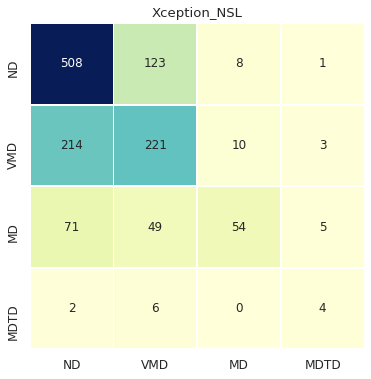

In [12]:
ADModelBuilder.plot_confusion_mat(model=graph_reg_model, data=data, data_label=data_label, title="Xception_NSL", figsize=(6,6))